<div class="alert alert-block alert-info" style="font-size:30px;">
    📌 &nbsp;<b><u>BTK Akademi Datathon 2024:</u></b><br>
* <i> 2014-2022 yılları arasında Girişimcilik Vakfı'na başvuran kişilerin, verdikleri kişisel bilgiler ve bu bilgilere dayanarak aldıkları değerlendirme puanlarına göre bir tahmin modeli oluşturulması hedeflenmektedir. Bu model, 2023 yılı başvuruları için değerlendirme puanlarını tahmin etmek amacıyla kullanılacaktır.</i><br>
</div>


In [1]:
!pip install unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from nltk import edit_distance
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata
from unidecode import unidecode
import re

pd.set_option('display.max_columns', 100)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 8.9 MB/s eta 0:00:00


<div class="alert alert-block alert-info" style="font-size:40px; color: red; font-weight: bold; text-align: center;">
     &nbsp;Veri İncelemesi<br>
</div>

In [2]:
train = pd.read_csv("/kaggle/input/datathon-2024/train.csv")
test = pd.read_csv("/kaggle/input/datathon-2024/test_x.csv")

il = pd.read_csv("/kaggle/input/il-lat-lon/7a4ba8531187fa8703ff1f22692d5fa6-df4e85262ba2a4f6d6045f06f417b853fb67e78c/il.csv")

tcopy = train.copy()

/tmp/ipykernel_17/1536287632.py:1: DtypeWarning: Columns (13,15,19,30,32,37,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/kaggle/input/datathon-2024/train.csv")


In [3]:
print("*****Eğitim veri seti*****")
train.info()

*****Eğitim veri seti*****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65125 entries, 0 to 65124
Data columns (total 44 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Basvuru Yili                                               65125 non-null  int64  
 1   Degerlendirme Puani                                        65124 non-null  float64
 2   Cinsiyet                                                   64956 non-null  object 
 3   Dogum Tarihi                                               64948 non-null  object 
 4   Dogum Yeri                                                 64334 non-null  object 
 5   Ikametgah Sehri                                            63088 non-null  object 
 6   Universite Adi                                             64993 non-null  object 
 7   Universite Turu                                            64870 no

In [4]:
print("*****Tahmin edilcek veri seti*****")
print(test.info())

*****Tahmin edilcek veri seti*****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11049 entries, 0 to 11048
Data columns (total 43 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Basvuru Yili                                               11049 non-null  int64  
 1   Cinsiyet                                                   11049 non-null  object 
 2   Dogum Tarihi                                               11049 non-null  object 
 3   Dogum Yeri                                                 11049 non-null  object 
 4   Ikametgah Sehri                                            11049 non-null  object 
 5   Universite Adi                                             11049 non-null  object 
 6   Universite Turu                                            11049 non-null  object 
 7   Burslu ise Burs Yuzdesi                                    

In [5]:
print("****Eğitim verisi kategorik değerlerin dağılımı****")

obj_cols = train.select_dtypes(include="object").columns
for col in obj_cols[:5]:
    print(train[col].value_counts())

****Eğitim verisi kategorik değerlerin dağılımı****
Cinsiyet
Kadın                    32077
Erkek                    22752
ERKEK                    10012
Belirtmek istemiyorum      115
Name: count, dtype: int64
Dogum Tarihi
1/1/70 2:00         1655
1/1/00 0:00          179
1/1/01 0:00          154
1/1/1997             139
1/1/1998             129
                    ... 
1992-05-12             1
1997-03-19             1
1996-08-17             1
1991-04-23             1
12.11.2003 00:00       1
Name: count, Length: 13498, dtype: int64
Dogum Yeri
İstanbul             8682
Ankara               4045
İzmir                2170
Istanbul             1894
Adana                1810
                     ... 
körfez/kocaeli          1
GEDIZ                   1
İstanbul Bakırköy       1
İstanbul-Şişli          1
Ankara keçiören         1
Name: count, Length: 2230, dtype: int64
Ikametgah Sehri
İstanbul               16625
Ankara                  6485
Istanbul                3469
İzmir               

In [6]:
print("****Test verisi kategorik değerlerin dağılımı****")
for col in obj_cols[:5]:
    print(test[col].value_counts())

****Test verisi kategorik değerlerin dağılımı****
Cinsiyet
Kadın                    6378
Erkek                    4654
Belirtmek istemiyorum      17
Name: count, dtype: int64
Dogum Tarihi
1.01.2002 00:00     135
1.01.2001 00:00      98
1.01.2003 00:00      87
1.01.2000 00:00      78
1.01.2004 00:00      54
                   ... 
10.05.1999 00:00      1
29.01.2004 00:00      1
16.07.2003 00:00      1
5.11.1999 00:00       1
1.10.2005 00:00       1
Name: count, Length: 2135, dtype: int64
Dogum Yeri
İstanbul      1814
Ankara         603
Diyarbakır     408
Hatay          384
Şanlıurfa      357
              ... 
Bartın          14
Yalova          14
KKTC            10
Tunceli          9
Bayburt          9
Name: count, Length: 83, dtype: int64
Ikametgah Sehri
İstanbul      3301
Ankara        1132
İzmir          509
Diyarbakır     327
Hatay          325
              ... 
Sinop           11
Çankırı         10
Bartın           9
Gümüşhane        8
Ardahan          6
Name: count, Length: 83, 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(70, 0.04, '2016 yılı')

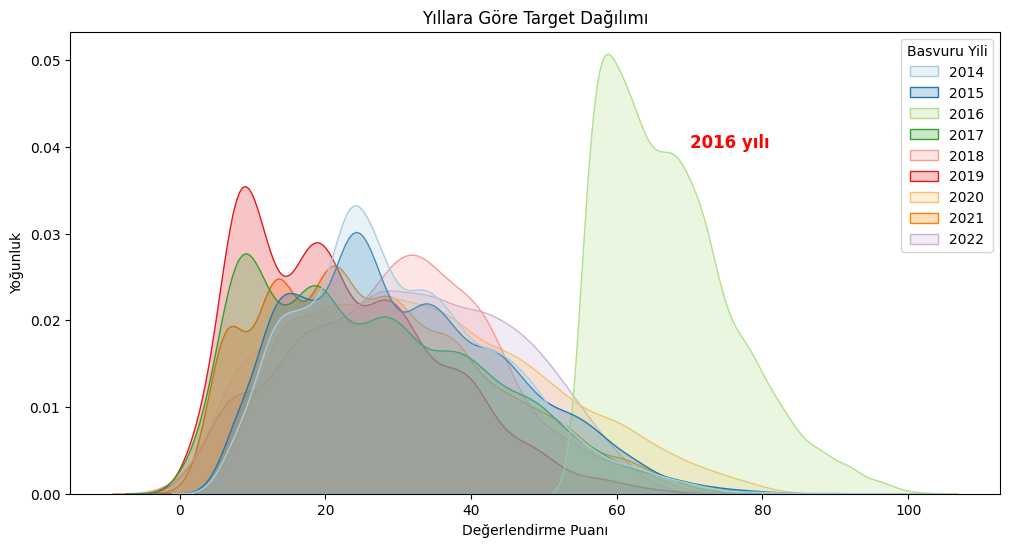

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.kdeplot(data=train, x="Degerlendirme Puani", hue="Basvuru Yili", fill=True, common_norm=False, palette="Paired")


plt.title('Yıllara Göre Target Dağılımı')
plt.xlabel('Değerlendirme Puanı')
plt.ylabel('Yoğunluk')

plt.text(70, 0.04, '2016 yılı', fontsize=12, color='red', weight='bold')  # x ve y koordinatlarını grafik yapınıza göre ayarlayın

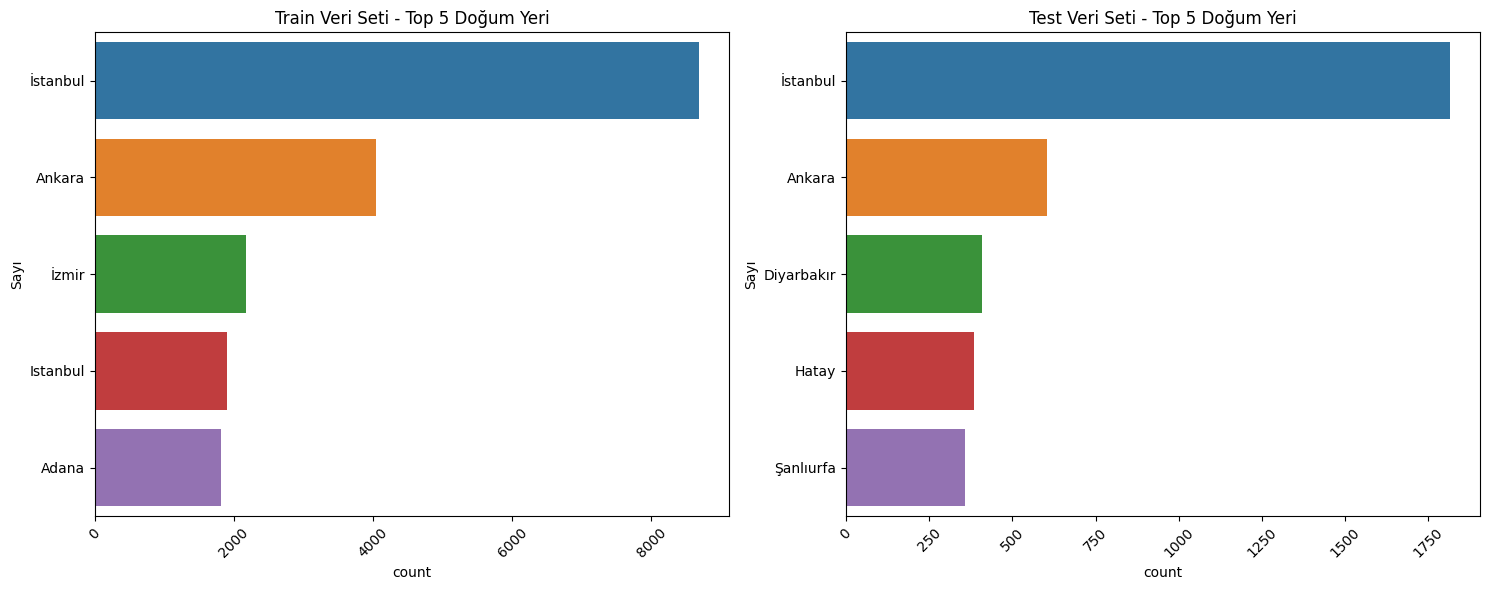

In [8]:
train_top5 = pd.DataFrame(train["Dogum Yeri"].value_counts().nlargest(5)).reset_index()
test_top5 = pd.DataFrame(test["Dogum Yeri"].value_counts().nlargest(5)).reset_index()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


sns.barplot(train_top5,x="count",y="Dogum Yeri",ax=ax1)
ax1.set_title('Train Veri Seti - Top 5 Doğum Yeri')
ax1.set_ylabel('Sayı')
ax1.tick_params(axis='x', rotation=45)


sns.barplot(test_top5,x="count",y="Dogum Yeri",ax=ax2)
ax2.set_title('Test Veri Seti - Top 5 Doğum Yeri')
ax2.set_ylabel('Sayı')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

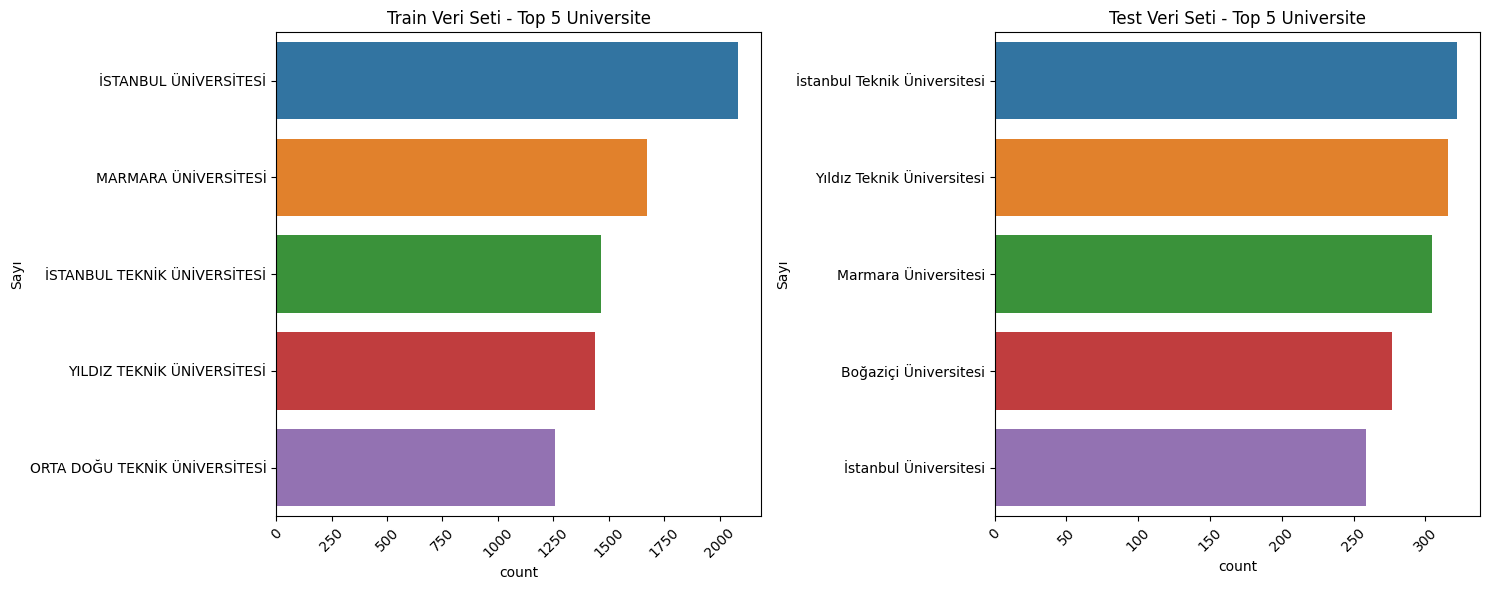

In [9]:
train_top5 = pd.DataFrame(train["Universite Adi"].value_counts().nlargest(5)).reset_index()
test_top5 = pd.DataFrame(test["Universite Adi"].value_counts().nlargest(5)).reset_index()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


sns.barplot(train_top5,x="count",y="Universite Adi",ax=ax1)
ax1.set_title('Train Veri Seti - Top 5 Universite')
ax1.set_ylabel('Sayı')
ax1.tick_params(axis='x', rotation=45)


sns.barplot(test_top5,x="count",y="Universite Adi",ax=ax2)
ax2.set_title('Test Veri Seti - Top 5 Universite')
ax2.set_ylabel('Sayı')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

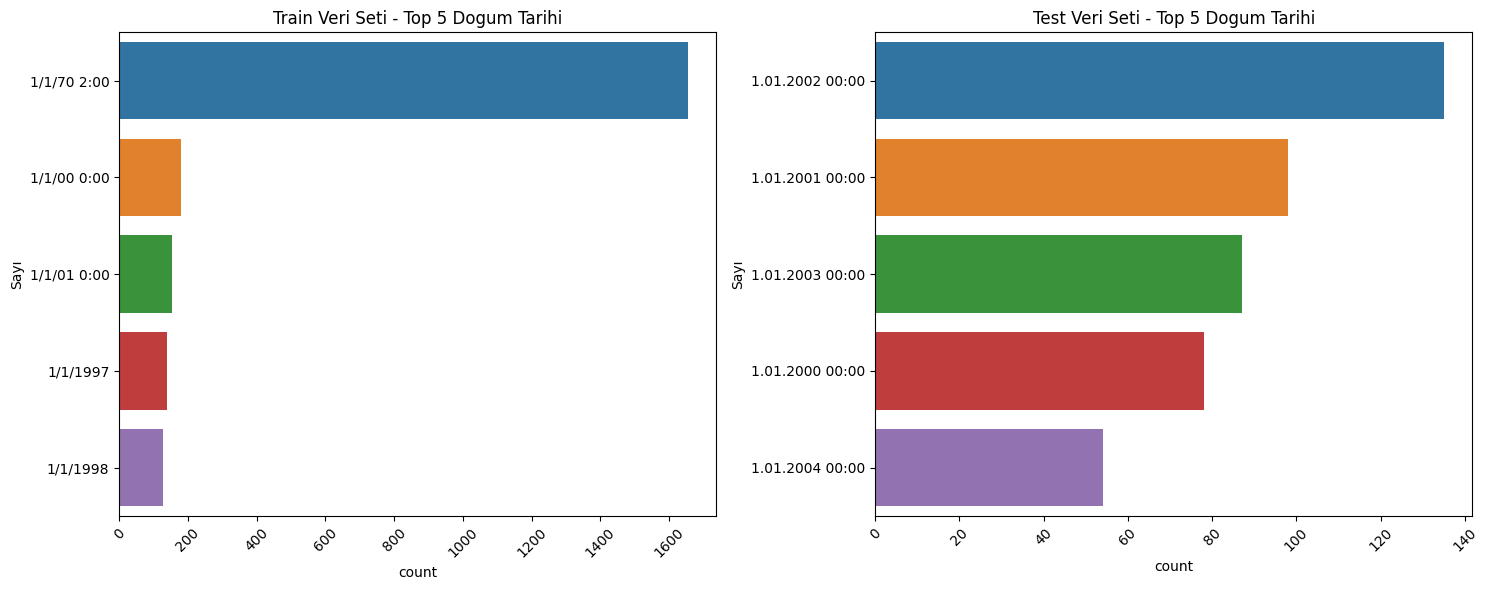

In [10]:
train_top5 = pd.DataFrame(train["Dogum Tarihi"].value_counts().nlargest(5)).reset_index()
test_top5 = pd.DataFrame(test["Dogum Tarihi"].value_counts().nlargest(5)).reset_index()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


sns.barplot(train_top5,x="count",y="Dogum Tarihi",ax=ax1)
ax1.set_title('Train Veri Seti - Top 5 Dogum Tarihi')
ax1.set_ylabel('Sayı')
ax1.tick_params(axis='x', rotation=45)


sns.barplot(test_top5,x="count",y="Dogum Tarihi",ax=ax2)
ax2.set_title('Test Veri Seti - Top 5 Dogum Tarihi')
ax2.set_ylabel('Sayı')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

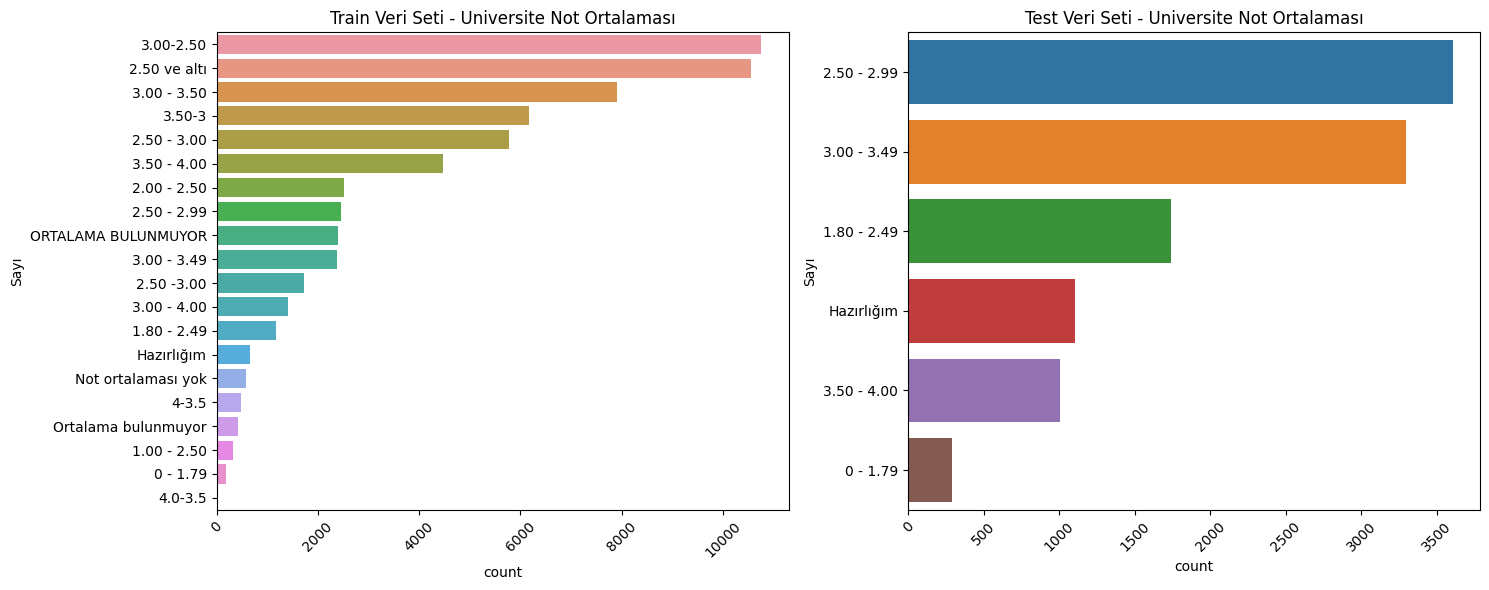

In [11]:
train_top5 = pd.DataFrame(train["Universite Not Ortalamasi"].value_counts()).reset_index()
test_top5 = pd.DataFrame(test["Universite Not Ortalamasi"].value_counts()).reset_index()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


sns.barplot(train_top5,x="count",y="Universite Not Ortalamasi",ax=ax1)
ax1.set_title('Train Veri Seti - Universite Not Ortalaması')
ax1.set_ylabel('Sayı')
ax1.tick_params(axis='x', rotation=45)


sns.barplot(test_top5,x="count",y="Universite Not Ortalamasi",ax=ax2)
ax2.set_title('Test Veri Seti - Universite Not Ortalaması')
ax2.set_ylabel('Sayı')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info" style="font-size:30px;">
    📊 &nbsp;<b><u>Başlıca Gözlemler</u></b><br>
* <i>Train verisinde bir çok değişkende eksik veri varken test verisinde ise bazı değişkenler tamamen boş yada tamamen dolu.</i><br>
* <i>Train verisetinde yazım yanlışı veya farklı yazımdan dolayı aynı değerler farklı bir değer gibi gözükebiliyor bu durum train ve test veriseti arasında uyumsuzluğa neden oluyor.</i><br> 
* <i>Trainde teste göre farklı veya fazladan kategoriler bulunabiliyor.</i><br> 

</div>


<div class="alert alert-block alert-info" style="font-size:40px; color: red; font-weight: bold; text-align: center;">
     &nbsp;Veri Temizleme<br>
</div>

### Değişken isimlerini daha kolay kullanabilmek için hepsini küçük harfe çevirdik ve boşlukları "_" ile birleştirdik.
### Üniversite Adi değişkenindeki değerler trainde büyük ve testte küçük olacak şekilde yazılmış bu yüzden bunun gibi hataları düzeltmek için tüm değişkenlere  unidecode ve lower fonksiyonlarını uyguladık. 

In [12]:
# kolon isimlerini daha rahat kullanabilmek için yeniden düzenliyoruz
train.columns = train.columns.str.lower().str.replace(' ', '_')
test.columns = test.columns.str.lower().str.replace(' ', '_')


# bazı durumlarda string değerler aynı gözüksede
# kod seviyesinde aynı değil unidecode ile bu türkçe karakterlerden dolayı oluşan sorunu çözdük. 
for col in train.select_dtypes(include=['object']).columns:
    train[col] = train[col].apply(lambda x: unidecode(str(x)).lower() if isinstance(x, str) else x)

for col in test.select_dtypes(include=['object']).columns:
    test[col] = test[col].apply(lambda x: unidecode(str(x)).lower() if isinstance(x, str) else x)
    
    

for col in il.select_dtypes(include=['object']).columns:
    il[col] = il[col].apply(lambda x: unidecode(str(x)).lower() if isinstance(x, str) else x)

### Çok fazla değişkeni olan kategorik veriler olduğu için  değişkenlerdeki anahtar kelimeleri yakalabilmek için countvectorizer kullandık. Her nekadar iyi bir yöntem olduğunu düşünmesekte, bunun yerine daha iyi ve detaylı bir özellik çıkarımı ile daha iyi ve stabil sonuçlar alınabilir. Fakat yarışma süresi bakımından yeterli zamanımız olmadığından bunu kullandık.

In [13]:
train['combined_text'] = train.apply(lambda row: ' '.join([
 
    str(row['cinsiyet']),
    str(row['dogum_tarihi']),
    str(row['dogum_yeri']),
    str(row['ikametgah_sehri']),
    str(row['universite_adi']),
    str(row['universite_turu']),
    str(row['burs_aliyor_mu?']),
    str(row['bölüm']),
    str(row['universite_kacinci_sinif']),
    str(row['universite_not_ortalamasi']),
    str(row['lise_adi']),
    str(row['lise_sehir']),
    str(row['lise_turu']),
    str(row['lise_bolumu']),
    str(row['lise_mezuniyet_notu']),
    str(row['baska_bir_kurumdan_burs_aliyor_mu?']),
    str(row['anne_egitim_durumu']),
    str(row['anne_calisma_durumu']),
    str(row['anne_sektor']),
    str(row['baba_egitim_durumu']),
    str(row['baba_calisma_durumu']),
    str(row['baba_sektor']),
    str(row['kardes_sayisi']),
    str(row['girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz?']),
    str(row['profesyonel_bir_spor_daliyla_mesgul_musunuz?']),
    str(row['spor_dalindaki_rolunuz_nedir?']),
    str(row['aktif_olarak_bir_stk_üyesi_misiniz?']),
    str(row['hangi_stk\'nin_uyesisiniz?']),
    str(row['girisimcilikle_ilgili_deneyiminiz_var_mi?']),
    str(row['girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz?']),
    str(row['ingilizce_biliyor_musunuz?'])
]), axis=1)


test['combined_text'] = test.apply(lambda row: ' '.join([
  
    str(row['cinsiyet']),
    str(row['dogum_tarihi']),
    str(row['dogum_yeri']),
    str(row['ikametgah_sehri']),
    str(row['universite_adi']),
    str(row['universite_turu']),
    str(row['burs_aliyor_mu?']),
    str(row['bölüm']),
    str(row['universite_kacinci_sinif']),
    str(row['universite_not_ortalamasi']),
    str(row['lise_adi']),
    str(row['lise_sehir']),
    str(row['lise_turu']),
    str(row['lise_bolumu']),
    str(row['lise_mezuniyet_notu']),
    str(row['baska_bir_kurumdan_burs_aliyor_mu?']),
    str(row['anne_egitim_durumu']),
    str(row['anne_calisma_durumu']),
    str(row['anne_sektor']),
    str(row['baba_egitim_durumu']),
    str(row['baba_calisma_durumu']),
    str(row['baba_sektor']),
    str(row['kardes_sayisi']),
    str(row['girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz?']),
    str(row['profesyonel_bir_spor_daliyla_mesgul_musunuz?']),
    str(row['spor_dalindaki_rolunuz_nedir?']),
    str(row['aktif_olarak_bir_stk_üyesi_misiniz?']),
    str(row['hangi_stk\'nin_uyesisiniz?']),
    str(row['girisimcilikle_ilgili_deneyiminiz_var_mi?']),
    str(row['girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz?']),
    str(row['ingilizce_biliyor_musunuz?'])
]), axis=1)



from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=10000)


X = vectorizer.fit_transform(train['combined_text'])
feature_names = vectorizer.get_feature_names_out()
mtrain = pd.DataFrame(X.toarray(), columns=feature_names)
X2 = vectorizer.transform(test['combined_text'])
mtest = pd.DataFrame(X2.toarray(), columns=feature_names)

In [14]:
# doğum tarihinin düzenlenmesi ve yaş özelliği oluşturulması
def keep_last_4_digits(value):
    if any(char.isalpha() for char in value):
        match = re.search(r'(\d{4})$', value)
        if match:
            return match.group(1)
    return value



train['dogum_tarihi'] = train['dogum_tarihi'].astype(str).apply(keep_last_4_digits)
train["dogum_tarihi"] =  pd.to_datetime(train.dogum_tarihi,format="mixed",errors="coerce")
test["dogum_tarihi"] =  pd.to_datetime(test.dogum_tarihi,format="mixed")



train = train.set_index(train.dogum_tarihi)
train["year"] =  train.index.year


test = test.set_index(test.dogum_tarihi)
test["year"] =  test.index.year


train.loc[train.year==2070.0,"year"]=np.nan
train.loc[train.year==2016.0,"year"]=np.nan
train.loc[train.year==2017.0,"year"]=np.nan
train.loc[train.year==2020.0,"year"]=np.nan
train.loc[train.year==1929.0,"year"]=np.nan
train.loc[train.year==2015.0,"year"]=np.nan
train.loc[train.year==1933.0,"year"]=np.nan
train.loc[train.year==2021.0,"year"]=np.nan
train.loc[train.year==1944.0,"year"]=np.nan
train.loc[train.year==1888.0,"year"]=np.nan
train.loc[train.year==1896.0,"year"]=np.nan
train.loc[train.year==1895.0,"year"]=np.nan
train.loc[train.year==2011.0,"year"]=np.nan


train.loc[train.year==1972.0,"year"]=np.nan
train.loc[train.year==1979.0,"year"]=np.nan
train.loc[train.year==1970.0,"year"]=np.nan
train.loc[train.year==1977.0,"year"]=np.nan

train.loc[train.year==1976.0,"year"]=np.nan
train.loc[train.year==1977.0,"year"]=np.nan
train.loc[train.year==1977.0,"year"]=np.nan
train.loc[train.year==1977.0,"year"]=np.nan



train["yas2"] =  train["basvuru_yili"] - train.year
test["yas2"] =  test["basvuru_yili"] - test.year



train.drop(["dogum_tarihi"],axis=1,inplace=True)
test.drop(["dogum_tarihi"],axis=1,inplace=True)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)


In [15]:
# açık uçlu sorulara yazılan yazıların uzunluğu ve kullanılan kelime sayısının işe yarabileceği ihitimali ile bu özellikler eklenmiştir.

train["len_stk"] = train["hangi_stk'nin_uyesisiniz?"].astype(str).apply(len)
test["len_stk"] = test["hangi_stk'nin_uyesisiniz?"].astype(str).apply(len)

train["len_girisim"] = train["girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz?"].astype(str).apply(len)
test["len_girisim"] = test["girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz?"].astype(str).apply(len)




train["word_count_stk"] = train["hangi_stk'nin_uyesisiniz?"].astype(str).apply(lambda x: len(x.split()))
test["word_count_stk"] = test["hangi_stk'nin_uyesisiniz?"].astype(str).apply(lambda x: len(x.split()))

train["word_count_girisim"] = train["girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz?"].astype(str).apply(lambda x: len(x.split()))
test["word_count_girisim"] = test["girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz?"].astype(str).apply(lambda x: len(x.split()))


### ikametgah şehri, lise şehri, bölüm gibi özelliklerde yanlış veya farklı yazımdan dolayı aynı değer olması gerekirken farklı gözükebiliyordu. Bunu azaltabilmek için dict oluşturduk. Bu dict ile farklı yazılanları belirli değerlere çevirdik. 

In [16]:
lise_sehir_düzenleme = {
    "------":"istanbul",
    "diger":np.nan,
    "afyon":"afyonkarahisar",
    'istanbul': 'istanbul',
    'ankara': 'ankara',
    'izmir': 'izmir',
    'bursa': 'bursa',
    'adana': 'adana',
    'antalya': 'antalya',
    'mersin': 'mersin',
    'kocaeli': 'kocaeli',
    'gaziantep': 'gaziantep',
    'konya': 'konya',
    'diyarbakir': 'diyarbakir',
    'hatay': 'hatay',
    'kayseri': 'kayseri',
    'sanliurfa': 'sanliurfa',
    'manisa': 'manisa',
    'van': 'van',
    'samsun': 'samsun',
    'malatya': 'malatya',
    'aydin': 'aydin',
    'denizli': 'denizli',
    'balikesir': 'balikesir',
    'mardin': 'mardin',
    'eskisehir': 'eskisehir',
    'tekirdag': 'tekirdag',
    'sakarya': 'sakarya',
    'kahramanmaras': 'kahramanmaras',
    'batman': 'batman',
    'erzurum': 'erzurum',
    'trabzon': 'trabzon',
    'adiyaman': 'adiyaman',
    'mugla': 'mugla',
    'ordu': 'ordu',
    'elazig': 'elazig',
    'sivas': 'sivas',
    'agri': 'agri',
    'corum': 'corum',
    'tokat': 'tokat',
    'zonguldak': 'zonguldak',
    'osmaniye': 'osmaniye',
    'canakkale': 'canakkale',
    'isparta': 'isparta',
    'kutahya': 'kutahya',
    'sirnak': 'sirnak',
    'bitlis': 'bitlis',
    'afyonkarahisar': 'afyonkarahisar',
    'mus': 'mus',
    'giresun': 'giresun',
    'edirne': 'edirne',
    'siirt': 'siirt',
    'aksaray': 'aksaray',
    'kirklareli': 'kirklareli',
    'amasya': 'amasya',
    'rize': 'rize',
    'kirikkale': 'kirikkale',
    'duzce': 'duzce',
    'nigde': 'nigde',
    'yozgat': 'yozgat',
    'karabuk': 'karabuk',
    'yalova': 'yalova',
    'usak': 'usak',
    'karaman': 'karaman',
    'bolu': 'bolu',
    'kirsehir': 'kirsehir',
    'nevsehir': 'nevsehir',
    'kars': 'kars',
    'kastamonu': 'kastamonu',
    'erzincan': 'erzincan',
    'igdir': 'igdir',
    'hakkari': 'hakkari',
    'burdur': 'burdur',
    'bilecik': 'bilecik',
    'bingol': 'bingol',
    'bartin': 'bartin',
    'sinop': 'sinop',
    'kilis': 'kilis',
    'artvin': 'artvin',
    'cankiri': 'cankiri',
    'bayburt': 'bayburt',
    'gumushane': 'gumushane',
    'ardahan': 'ardahan',
    'tunceli': 'tunceli',
    'bandirma': 'balikesir',
    'nazilli': 'aydin',
    'antakya': 'hatay',
    'tarsus': 'mersin',
    'izmit': 'kocaeli',
    'iskenderun': 'hatay',
    'ceyhan': 'adana',
    'unye': 'ordu',
    'manavgat': 'antalya',
    'kdz.eregli': 'zonguldak',
    'tarsus/mersin': 'mersin',
    'alanya': 'antalya',
    'inegol': 'bursa',
    'fethiye': 'mugla',
    'mersin/tarsus': 'mersin',
    'gebze': 'kocaeli',
    'baku': 'azerbaijan',
    'luleburgaz': 'kirklareli',
    'turhal/tokat': 'tokat',
    'zile': 'tokat',
    'marmaris': 'mugla',
    'corlu': 'tekirdag',
    'istabul': 'istanbul',
    'seydisehir': 'konya',
    'edremit': 'balikesir',
    'corlu/tekirdag': 'tekirdag',
    'siverek': 'sanliurfa',
    'fatih': 'istanbul',
    's.urfa': 'sanliurfa',
    'tekirdag/corlu': 'tekirdag',
    'bursa inegol': 'bursa',
    'turhal': 'tokat',
    'kutahya/tavsanli': 'kutahya',
    'silopi': 'sirnak',
    'kocaeli izmit': 'kocaeli',
    'eregli': 'zonguldak',
    'samsun/bafra': 'samsun',
    'erbaa': 'tokat',
    'kahta': 'adiyaman',
    'akhisar/manisa': 'manisa',
    'salihli': 'manisa',
    'aydin/nazilli': 'aydin',
    'sanliurfa/hilvan': 'sanliurfa',
    'soma': 'manisa',
    'zakatala': 'azerbaijan',
    'bozuyuk/bilecik': 'bilecik',
    'adiyaman/kahta': 'adiyaman',
    'manisa/turgutlu': 'manisa',
    'karamursel/kocaeli': 'kocaeli',
    'bandirma/balikesir': 'balikesir',
    'silifke': 'mersin',
    'silivri': 'istanbul',
    'izmir tire': 'izmir',
    'aydin/kusadasi': 'aydin',
    'antakya hatay': 'hatay',
    'soke/aydin': 'aydin',
    'menemen': 'izmir',
    'turgutlu/manisa': 'manisa',
    'edirne/uzunkopru': 'edirne',
    'nusaybin': 'mardin',
    'anamur/mersin': 'mersin',
    'konya / eregli': 'konya',
    'zonguldak/devrek': 'zonguldak',
    'sanliurfa/viransehir': 'sanliurfa',
    'boyabat/sinop': 'sinop',
    'cerkezkoy': 'tekirdag',
    'beypazari': 'ankara',
    'polatli': 'ankara',
    'tire/izmir': 'izmir',
    'umraniye': 'istanbul',
    'ermenek/karaman': 'karaman',
    'izmir bergama': 'izmir',
    'akhisar': 'manisa',
    'odemis': 'izmir',
    'boyabat': 'sinop',
    'gebze/kocaeli': 'kocaeli',
    'turgutlu': 'manisa',
    'alanya/antalya': 'antalya',
    'istanbuk': 'istanbul',
    'corlu/ tekirdag': 'tekirdag',
    'manisa-turgutlu': 'manisa',
    'tavsanli': 'kutahya',
    'gazipasa': 'antalya',
    'hatay iskenderun': 'hatay',
    'mersin tarsus': 'mersin',
    'nazilli / aydin': 'aydin',
    'samsun-terme': 'samsun',
    'zonguldak eregli': 'zonguldak',
    'darica/kocaeli': 'kocaeli',
    'balikesir/susurluk': 'balikesir',
    'mustafakemalpasa/bursa': 'bursa',
    'zonguldak/eregli': 'zonguldak',
    'beylikduzu': 'istanbul',
    'burdur/bucak': 'burdur',
    'sarigol/manisa': 'manisa',
    'karasu / sakarya': 'sakarya',
    'osmaniye/toprakkale': 'osmaniye',
    'bayrampasa': 'istanbul',
    'kusadasi/aydin': 'aydin',
    'almanya': 'germany',
    'patnos/agri': 'agri',
    'milas': 'mugla',
    'tepebasi': 'eskisehir',
    'nigde/bor': 'nigde',
    'suleymanpasa': 'tekirdag',
    'tarsus': 'mersin',
    'azerbaijan': 'yurt disi',
    'kdz. eregli/zonguldak': 'zonguldak',
    'izmit/ kocaeli': 'kocaeli',
    'g.antep': 'gaziantep',
    'bakioglu': 'yurt disi',
    'canakkale/biga': 'canakkale',
    'akdagmadeni': 'yozgat',
    'bilecikbozuyuk': 'bilecik',
    'ankara-cankaya': 'ankara',
    'inegol/bursa': 'bursa',
    'kartepe/kocaeli': 'kocaeli',
    'mersin-sinop': 'mersin',
    'kahmanmaras /afsin': 'kahramanmaras',
    'ord': 'ordu',
    'trabzon /of': 'trabzon',
    'tranzon': 'trabzon',
    'mugla merkez': 'mugla',
    'akcakoca': 'düzce',
    'alasehirmanisa': 'manisa',
    'havran balikesir': 'balıkesir',
    'konya eregli': 'konya',
    'hatay-antakya': 'hatay',
    'suluova': 'amasya',
    'golcuk/kocaeli': 'kocaeli',
    'bornova': 'izmir',
    'seki': 'bartın',
    'gaziantep/nizip': 'gaziantep',
    'van - elazig': 'van',
    'germncik/aydin': 'aydın',
    'tosya': 'kastamonu',
    'bucak-burdur': 'burdur',
    'kadirli': 'osmaniye',
    'aantalya': 'antalya',
    'edirne kesan': 'edirne',
    'sinopboyabat': 'sinop',
    'tuzla/istanbul': 'istanbul',
    'kusadasi': 'aydın',
    'mardin-midyat': 'mardin',
    'izmir/kiraz': 'izmir',
    'balikesir/ayvalik': 'balıkesir',
    'zile/tokat': 'tokat',
    'bursa gemlik': 'bursa',
    'gumusyaka': 'kocaeli',
    'kastamonu/inebolu': 'kastamonu',
    'kirsehir / kaman': 'kırşehir',
    'germany': 'yurt disi',
    'istanbul/yesilkoy': 'istanbul',
    'salihli/manisa': 'manisa',
    'erzurum/oltu': 'erzurum',
    'besni': 'adıyaman',
    'manisa /turgutlu': 'manisa',
    'yuksekova': 'hakkari',
    'denizli/tavas': 'denizli',
    'amasya/merzifon': 'amasya',
    'bigadic': 'balıkesir',
    'sinop/boyabat': 'sinop',
    'birecik/ sanli urfa': 'sanlıurfa',
    'pasinler/erzurum': 'erzurum',
    'cubuk': 'ankara',
    'azerbaycan / baku': 'yurt disi',
    'burdur/golhisar': 'burdur',
    'viransehie': 'şanlıurfa',
    'aksehir': 'konya',
    'serik/antalya': 'antalya',
    'pendik': 'istanbul',
    'aksehir, konya': 'konya',
    'borcka': 'artvin',
    'kocaeli-darica': 'kocaeli',
    'bozyazi': 'mersin',
    'konya /eregli': 'konya',
    'kumluca antlaya': 'antalya',
    'luleburgaz/kirklareli': 'kırklareli',
    'kartal/ist.': 'istanbul',
    'odemis/izmir': 'izmir',
    'susehri/ sivas': 'sivas',
    'tekirdagmuratli': 'tekirdağ',
    'bolu/goynuk': 'bolu',
    'hatay/antakya': 'hatay',
    'hatay-dortyol': 'hatay',
    'izmir/kemalpasa/ulucak': 'izmir',
    'tokat / erbaa': 'tokat',
    'cizre': 'şırnak',
    'mardin-kiziltepe': 'mardin',
    'tire/ izmir': 'izmir',
    'silvan/diyarbakir': 'diyarbakır',
    'sorgun': 'yozgat',
    'havsa/edirne': 'edirne',
    'koyulhisar': 'sivas',
    'aliaga': 'izmir',
    'hatay kirikhan': 'hatay',
    'kagithane': 'istanbul',
    'villefranche sur saone': 'yurt disi',
    'batman/merkez': 'batman',
    'seydikemer / mugla': 'mugla',
    'konya /seydisehir': 'konya',
    'yozgat /sorgun': 'yozgat',
    'turkiye': 'yurt disi',
    'corlu / tekirdag': 'tekirdağ',
    'izmir/bergama': 'izmir',
    'adana/kozan': 'adana',
    'edremit / balikesir': 'balıkesir',
    'ist': 'istanbul',
    'soke': 'aydın',
    'istanbul/beyoglu': 'istanbul',
    'karabbuk': 'karabük',
    'vakfikebir': 'trabzon',
    'canakkale/can': 'çanakkale',
    'bulut': 'yurt disi',
    'bingol-genc': 'bingöl',
    'diyarbakir cinar': 'diyarbakır',
    'ankara, balikesir': 'ankara',
    'istanbul/esenyurt': 'istanbul',
    'aydin soke': 'aydın',
    'kesan/edirne': 'edirne',
    'viransehir': 'şanlıurfa',
    'urun': 'yurt disi',
    'nizipgaziantep': 'gaziantep',
    'bilecik-merkez': 'bilecik',
    'gonen- balikesir': 'balıkesir',
    'balikesir/edremit': 'balıkesir',
    'artvin arhavi': 'artvin',
    'izmir/tire': 'izmir',
    'dortyol': 'hatay',
    'erenkoy-istanbul': 'istanbul',
    'afyon, izmir': 'afyonkarahisar',
    'marmaris/mugla': 'muğla',
    'manisa/salihli': 'manisa',
    'bafra': 'samsun',
    'cizre / sirnak': 'şırnak',
    'hatay3 yil-osmaniye1': 'hatay',
    'ankar': 'ankara',
    'istanbul heybeliada': 'istanbul',
    'balikesir - savastepe': 'balıkesir',
    'agri/dogubeyazit': 'ağrı',
    'ankara / polatli': 'ankara',
    'alasehir': 'manisa',
    'agri/ patnos': 'ağrı',
    'mut - mersin': 'mersin',
    'tosya/kastamonu': 'kastamonu',
    'izmir aliaga': 'izmir',
    'kdz eregli': 'zonguldak',
    'bursa-yenisehir': 'bursa',
    'balikesir/bandirma': 'balıkesir',
    'silvan / diyarbakir': 'diyarbakır',
    'burhaniye/balikesir': 'balıkesir',
    'hatay antakya': 'hatay',
    'gebe': 'yurt disi',
    'mrsin': 'mersin',
    'eskisehir/sivrihisar': 'eskişehir',
    'muratli/tekirdag': 'tekirdağ',
    'mut/mersin': 'mersin',
    'maden/ elazig': 'elazığ',
    'silivri/istanbul': 'istanbul',
    'manisa/alasehir': 'manisa',
    'unye / ordu': 'ordu',
    'bafra/samsun': 'samsun',
    'merkez/kastamonu': 'kastamonu',
    'corlu/velimese': 'tekirdağ',
    'maltepe / istanbul': 'istanbul',
    'pertek/tunceli': 'tunceli',
    'kocaeli/gebze': 'kocaeli',
    'cine/aydin': 'aydın',
    'igdir / istanbul / istanbul': 'istanbul',
    'istanbul kartal': 'istanbul',
    'silifke / mersin': 'mersin',
    'erzurum /pasinler': 'erzurum',
    'balikesir/manyas': 'balıkesir',
    'iskenderun / hatay': 'hatay',
    'zonguldak merkez': 'zonguldak',
    'usak/banaz': 'uşak',
    'derik': 'mardin',
    'bucak': 'burdur',
    'samsun/carsamba': 'samsun',
    'kucukcekmece-ist.': 'istanbul',
    'balikesir/gonen': 'balıkesir',
    'sorgun/yozgat': 'yozgat',
    'ergani': 'diyarbakır',
    'istanbul zeytinburnu': 'istanbul',
    'uskudar': 'istanbul',
    'konya-karapinar': 'konya',
    'sumgayit': 'yurt disi',
    'afyon - sandikli': 'afyonkarahisar',
    'van/muradiye': 'van',
    'gazipasa/antalya': 'antalya',
    'suriye, lazkiye': 'yurt disi',
    'amasya/suluova': 'amasya',
    'mardin kiziltepe': 'mardin',
    'adana/ceyhan': 'adana',
    'sanliurfa/ merkez': 'şanlıurfa',
    'istanbu': 'istanbul',
    'kemer': 'antalya',
    'hatay/kirikhan': 'hatay',
    'adiyaman golbasi': 'adiyaman',
    'yatagan/mugla': 'muğla',
    'antalya / gazipasa': 'antalya',
    'corly': 'tekirdağ',
    'siverek / s.urfa': 'şanlıurfa',
    'bagcilar/istanbul': 'istanbul',
    'gurun/sivas': 'sivas',
    'shirvan': 'yurt disi',
    'sanliyrfa-viransehir': 'şanlıurfa',
    'orhangazi/bursa': 'bursa',
    'uzunkopru/edirne': 'edirne',
    'shkoder': 'yurt disi',
    'korkuteli/antalya': 'antalya',
    'antalya manavgat': 'antalya',
    'alanya / antalya': 'antalya',
    'gonen / balikesir': 'balıkesir',
    'manisa alasehir': 'manisa',
    'aliaga / izmir': 'izmir',
    'alapli/zonguldak': 'zonguldak',
    'istanbul/gungoren': 'istanbul',
    'yenisehir/bursa': 'bursa',
    'sariyer': 'istanbul',
    'midyat': 'mardin',
    'osmangazi/bursa': 'bursa',
    'elbistan/kahramanmaras': 'kahramanmaras',
    'konya ~ ilgin': 'konya',
    'mugla/merkez': 'muğla',
    'kirklareli/babaeski': 'kırklareli',
    'dogubayazit/agri': 'ağrı',
    'kirikhan': 'hatay',
    'agri patnos': 'ağrı',
    'orhangazi / bursa': 'bursa',
    'dortyol/hatay': 'hatay',
    'sivas -gemerek': 'sivas',
    'antalya/van': 'antalya',
    'bucak / burdur': 'burdur',
    'yahyali': 'kayseri',
    'manisa /akhisar': 'manisa',
    'esme/usak': 'uşak',
    'nizip': 'gaziantep',
    'asdasd': 'yurt disi',
    'sancaktepe': 'istanbul',
    'yerkoy/yozgat': 'yozgat',
    'peshawar': 'yurt disi',
    'manisa - salihli': 'manisa',
    'manisa - akhisar': 'manisa',
    'bozuyuk / bilecik': 'bilecik',
    'sanliurfa/karakopru': 'sanlıurfa',
    'istanbul maltepe': 'istanbul',
    'soma/manisa': 'manisa',
    'manisa salihli': 'manisa',
    'atyrau': 'yurt disi',
    'denizl': 'denizli',
    'duzici': 'osmaniye',
    'kolej': 'yurt disi',
    'kartal-istanbul': 'istanbul',
    'simav/kutahya': 'kutahya',
    'alanya-antalya': 'antalya',
    'milas/ mugla': 'muğla',
    'ferizaj-kosova': 'yurt disi',
    'erzurun': 'erzurum',
    'bodrum': 'muğla',
    'tokat merkez': 'tokat',
    'kurkcu': 'yurt disi',
    'abd missouri': 'yurt disi',
    'antaya': 'antalya',
    'istanbul - besiktas': 'istanbul',
    'samsun / bafra': 'samsun',
    'gemlik': 'bursa',
    'istanbul anadolu': 'istanbul',
    'kahramanmaas': 'kahramanmaras',
    'kocaeli- izmit': 'kocaeli',
    'montezuma/new mexico': 'yurt disi',
    'balikesir - edremit': 'balıkesir',
    'sakarya /sapanca': 'sakarya',
    'konya/cumra': 'konya',
    'bursa/gemlik': 'bursa',
    'kahramanmras': 'kahramanmaraş',
    'yilmaz': 'yurt disi',
    'izmit/karamursel': 'kocaeli',
    'tekirdag,istanbul': 'tekirdag',
    'istanbul buyukcekmece': 'istanbul',
    'lefkosa': 'yurt disi',
    'kasyeri': 'kayseri',
    'mustafakemalpasa': 'bursa',
    'adana/seyhan': 'adana',
    'amasya merzifon': 'amasya',
    'izmir/foca, karabuk/safranbolu': 'izmir',
    'istanbul-uskudar': 'istanbul',
    ':ankara': 'ankara',
    'ankara/polatli': 'ankara',
    'bodrum/mugla': 'muğla',
    'canakklale': 'çanakkale',
    'kiraz/izmir': 'izmir',
    'kocaeli/karamursel': 'kocaeli',
    'bursa/inegol': 'bursa',
    'giresun -gorele': 'giresun',
    'safranbolu': 'karabük',
    'gorele': 'giresun',
    'hatay- dortyol': 'hatay',
    'aydin-yalova': 'aydın',
    'amasya tasova': 'amasya',
    'rize/ardesen': 'rize',
    'kocaeli-cayirova': 'kocaeli',
    'karaman/ermenek': 'karaman',
    'ayvalik/balikesir': 'balıkesir',
    'siverek /sanliurfa': 'şanlıurfa',
    'bursa - yildirim': 'bursa',
    'sandikli': 'afyonkarahisar',
    'sivas/ gurun': 'sivas',
    'salihli manisa': 'manisa',
    'kocaeli/darica': 'kocaeli',
    'iznik bursa': 'bursa',
    'samsun bafra': 'samsun',
    'yesilkoy': 'istanbul',
    'istanbul/sile': 'istanbul',
    'kocaei': 'kocaeli',
    'corum/sungurlu': 'çorum',
    'bergama/izmir': 'izmir',
    'mardin nusaybin': 'mardin',
    'kesan / edirne': 'edirne',
    'hatay/iskenderun': 'hatay',
    'manavgat/antalya': 'antalya',
    'izmir/cesme': 'izmir',
    'esenler': 'istanbul',
    'agri/patnos': 'ağrı',
    'istanbul-kucukcekmece': 'istanbul',
    'bergama /izmir': 'izmir',
    'unye/ordu': 'ordu',
    'edirne / kesan': 'edirne',
    'istanbul tuzla': 'istanbul',
    'bakirkoy': 'istanbul',
    'uskudar / istanbul': 'istanbul',
    'samsun terme': 'samsun',
    'kdz.eregli / zonguldak': 'zonguldak',
    'izmit/kocaeli': 'kocaeli',
    'kesan': 'edirne',
    'kinshasa': 'yurt disi',
    'afsin / kahramanmaras': 'kahramanmaras',
    'kurucasile/bartin': 'bartın',
    'istanbulkucukcekmece': 'istanbul',
    'fethiye/mugla': 'muğla',
    'trabzon/of': 'trabzon',
    'luleburgaz / kirklareli': 'kırklareli',
    'corlu-tekirdag': 'tekirdağ',
    'ates': 'yurt disi',
    'edirne/kesan': 'edirne',
    'narman': 'erzurum',
    'saray/tekirdag': 'tekirdağ',
    'lefkosa/kktc': 'yurt disi',
    'gonen': 'balıkesir',
    'karabuk/yenice': 'karabük',
    'aksehir/konya': 'konya',
    'bakirkoy/istanbul': 'istanbul',
    'silopi/sirnak': 'şırnak',
    'manisa-soma': 'manisa',
    'balikesir-burhaniye': 'balıkesir',
    'diyarakir': 'diyarbakır',
    'merkez /elazig': 'elazığ',
    'polatli-ankara': 'ankara',
    'ercis': 'van',
    'beysehir': 'konya',
    'tekirdag/ saray': 'tekirdağ',
    'isyanbul': 'istanbul',
    'balikesir-gonen': 'balıkesir',
    'konya/eregli': 'konya',
    'sanliurfa/ceylanpinar': 'şanlıurfa',
    'bursa mudanya': 'bursa',
    'nazilli/aydin': 'aydın',
    'duzce/akcakoca': 'düzce',
    'istanbul/ besiktas': 'istanbul',
    'samsun - carsamba': 'samsun',
    'malatua': 'yurt disi',
    'maltepe': 'istanbul',
    'ayvalik': 'balıkesir',
    'cesme/izmir': 'izmir',
    'ankata': 'yurt disi',
    'soke, aydin': 'aydın',
    'isranbul': 'istanbul',
    'biga/canakkale': 'çanakkale',
    'polatli/ankara': 'ankara',
    'antalya/alanya': 'antalya',
    'amasya - suluova': 'amasya',
    'kastamony': 'karabük',
    'adana/ kozan': 'adana',
    'bafrasamsun': 'samsun',
    'bursa / orhangazi': 'bursa',
    'antalya alanya': 'antalya',
    'balikesir edremit': 'balıkesir',
    'konya karapinar': 'konya',
    'eskiseir': 'eskişehir',
    'tursunzade': 'yurt disi',
    'k.maras' : "kahramanmaras"
}



category_mapping = {
    'istanbul': 'istanbul', 'ankara': 'ankara', 'izmir': 'izmir', 'diyarbakir': 'diyarbakir', 
    'hatay': 'hatay', 'bursa': 'bursa', 'gaziantep': 'gaziantep', 'adana': 'adana', 
    'sanliurfa': 'sanliurfa', 'kocaeli': 'kocaeli', 'konya': 'konya', 'kayseri': 'kayseri', 
    'van': 'van', 'kahramanmaras': 'kahramanmaras', 'antalya': 'antalya', 'mardin': 'mardin', 
    'eskisehir': 'eskisehir', 'mersin': 'mersin', 'malatya': 'malatya', 'adiyaman': 'adiyaman', 
    'aydin': 'aydin', 'manisa': 'manisa', 'samsun': 'samsun', 'batman': 'batman', 
    'sakarya': 'sakarya', 'elazig': 'elazig', 'trabzon': 'trabzon', 'erzurum': 'erzurum', 
    'sirnak': 'sirnak', 'agri': 'agri', 'balikesir': 'balikesir', 'mugla': 'mugla', 
    'denizli': 'denizli', 'tekirdag': 'tekirdag', 'osmaniye': 'osmaniye', 'sivas': 'sivas', 
    'afyonkarahisar': 'afyonkarahisar', 'hakkari': 'hakkari', 'ordu': 'ordu', 'siirt': 'siirt', 
    'isparta': 'isparta', 'bitlis': 'bitlis', 'kars': 'kars', 'mus': 'mus', 
    'canakkale': 'canakkale', 'tokat': 'tokat', 'corum': 'corum', 'kilis': 'kilis', 
    'aksaray': 'aksaray', 'zonguldak': 'zonguldak', 'yozgat': 'yozgat', 'kutahya': 'kutahya', 
    'bingol': 'bingol', 'nigde': 'nigde', 'giresun': 'giresun', 'bolu': 'bolu', 
    'karabuk': 'karabuk', 'kastamonu': 'kastamonu', 'usak': 'usak', 'tunceli': 'tunceli', 
    'erzincan': 'erzincan', 'amasya': 'amasya', 'edirne': 'edirne', 'nevsehir': 'nevsehir', 
    'yalova': 'yalova', 'burdur': 'burdur', 'duzce': 'duzce', 'kktc': 'kktc', 
    'rize': 'rize', 'igdir': 'igdir', 'karaman': 'karaman', 'kirikkale': 'kirikkale', 
    'kirsehir': 'kirsehir', 'kirklareli': 'kirklareli', 'artvin': 'artvin', 'bayburt': 'bayburt', 
    'yurt disi': 'yurt disi', 'bilecik': 'bilecik', 'sinop': 'sinop', 'cankiri': 'cankiri', 
    'bartin': 'bartin', 'gumushane': 'gumushane', 'ardahan': 'ardahan',
    
    # Hatalı veya geçersiz yerler
    'diger': 'istanbul',
    'k.maras': 'kahramanmaras',
    'afyon': 'afyonkarahisar',
    '------': 'istanbul',
    'izmit': 'kocaeli',
    'antakya': 'hatay',
    'stanbul': 'istanbul',
    'adapazari': 'sakarya',
    'lefkosa': 'kktc',
    'girne': 'kktc',
    'uskudar/istanbul': 'istanbul',
    'iskenderun': 'hatay',
    'gothamcity': 'batman',
    'gazimagusa': 'kktc',
    'atasehir/istanbul': 'istanbul',
    'gaziosmanpasa/istanbul': 'istanbul',
    'maltepe/istanbul': 'istanbul',
    'gebze': 'kocaeli',
    'oslo': 'yurt disi',
    'esenyurt/istanbul': 'istanbul',
    'openairequestfailedtimeout': 'istanbul',
    'besiktas/istanbul': 'istanbul',
    'gebze/kocaeli': 'kocaeli',
    'lefke': 'kktc',
    'fatih/istanbul': 'istanbul',
    'sariyer/istanbul': 'istanbul',
    'gungoren/istanbul': 'istanbul',
    'avcilar/istanbul': 'istanbul',
    'ortaca/mugla': 'mugla',
    'soke/aydin': 'aydin',
    'gundogmus/antalya': 'antalya',
    'odtu/cankaya/ankara': 'ankara',
    'nilufer/bursa': 'bursa',
    'esenler/istanbul': 'istanbul',
    'mamak/ankara': 'ankara',
    'bakirkoy/istanbul': 'istanbul',
    'odunpazari/eskisehir': 'eskisehir',
    'fethiye/mugla': 'mugla',
    'akhisar/manisa': 'manisa',
    'bagcilar/istanbul': 'istanbul',
    'kepez/antalya': 'antalya',
    'cirishanee': 'bursa',
    'yenibosna/istanbul': 'istanbul',
    'sincan/ankara': 'ankara',
    'darica/kocaeli': 'kocaeli',
    'derince/kocaeli': 'kocaeli',
    'merkez/kastamonu': 'kastamonu',
    'manavgat': 'antalya',
    'mersin-adana': 'mersin',
    'alanya': 'antalya',
    'uskudar': 'istanbul',
    'bandirma': 'balikesir',
    'istanbul,kocaeli': 'kocaeli',
    'bucak': 'burdur',
    'fethiye': 'mugla',
    'bagcilar': 'istanbul',
    'baku': 'yurt disi',
    'cerkezkoy': 'tekirdag',
    'fatih': 'istanbul',
    'selcuk,izmir': 'izmir',
    'melikgazi/kayseri': 'kayseri',
    'bozuyuk': 'bilecik',
    'yenisehir': 'bursa',
    'kusadasi': 'izmir',
    'kahta': 'adiyaman',
    'kaman/kirsehir': 'kirsehir',
    'gole': 'ardahan',
    'bodrum': 'mugla',
    'gotham': 'batman',
    'orhangazi/bursa': 'bursa',
    'bilkent/ankara': 'ankara',
    'bornova/izmir': 'izmir',
    'caycuma/zonguldak': 'zonguldak',
    'dilovasi/kocaeli': 'kocaeli',
    'gemlik/bursa': 'bursa',
    'batman/merkez': 'batman',
    'istanbul\nnigde': 'nigde',
    'kirgizistan-biskek': 'yurt disi',
    'alapli/zonguldak': 'zonguldak',
    'cankaya/ankara': 'ankara',
    'ferikoy/istanbul': 'istanbul',
    'hamburg': 'yurt disi',
    'zeytinburnu/istanbul': 'istanbul',
    'yahyali/kayseri': 'kayseri',
    'bahcelievler/istanbul': 'istanbul',
    'bahcesehir/istanbul': 'istanbul',
    'polatli/ankara': 'ankara',
    'kagithane/istanbul': 'istanbul',
    'unye/ordu': 'ordu',
    'guzelyurt': 'kktc',
    'arhavi': 'artvin',
    'golcuk': 'kocaeli',
    'etimesgut/ankara': 'ankara',
    'florya/istanbul': 'istanbul',
    'buca/izmir': 'izmir',
    'aliaga/izmir': 'izmir',
    'palandoken/erzurum': 'erzurum',
    'cigli/izmir': 'izmir',
    'bigadic/balikesir': 'balikesir',
    'odtu/ankara': 'ankara',
    'beylikduzu/istanbul': 'istanbul',
    'hacettepe/ankara': 'ankara',
    'sile/istanbul': 'istanbul',
    'eryaman/ankara': 'ankara',
    'kadikoy/istanbul': 'istanbul',
    'balcova/izmir': 'izmir',
    'bahcelievler/ankara': 'ankara',
    'kecioren/ankara': 'ankara',
    'yunusemre/manisa': 'manisa',
    'silivri/istanbul': 'istanbul',
    'nurnberg': 'yurt disi',
    'kocamustafapasa/fatih/istanbul': 'istanbul',
    'germencik/aydin': 'aydin',
    'adapazari/sakarya': 'sakarya',
    'seyhan/adana': 'adana',
    'kartal/istanbul': 'istanbul',
    'baglar/diyarbakir': 'diyarbakir',
    'gonen/balikesir': 'balikesir',
    'konak/izmir': 'izmir',
    'akcaabat': 'trabzon'
}









categories = {
    'elektrik elektronik muhendisligi': 'elektrik-elektronik muhendisligi',
    'tip fakultesi': 'tip',
    'isletme(ingilizce)': 'isletme',
    'iktisat (ekonomi)': 'iktisat',
    'hemsirelik (fakulte)': 'hemsirelik',
    'endustri muhendisligi(ingilizce)': 'endustri muhendisligi',
    'hukuk fakultesi': 'hukuk',
    'bilgisayar muhendisligi(ingilizce)': 'bilgisayar muhendisligi',
    'makina muhendisligi': 'makine muhendisligi',
    'iktisat(ingilizce)': 'iktisat',
    'elektrik-elektronik muhendisligi(ingilizce)': 'elektrik-elektronik muhendisligi',
    'bilgisayar programciligi': 'bilgisayar muhendisligi',
    'ingilizce isletme': 'isletme',
    'makine muhendisligi(ingilizce)': 'makine muhendisligi',
    'psikolojik danismanlik ve rehberlik': 'rehberlik ve psikolojik danismanlik',
    'yonetim bilisim sistemleri (fakulte)': 'yonetim bilisim sistemleri',
    'veterinerlik': 'veteriner',
    'ingilizce iktisat': 'iktisat',
    'fizyoterapi ve rehabilitasyon (fakulte)': 'fizyoterapi ve rehabilitasyon',
    'endustri muhendisligi(ingilizce)(tam burslu)': 'endustri muhendisligi',
    'insaat muhendisligi(ingilizce)': 'insaat muhendisligi',
    'hemsirelik (yuksekokul)': 'hemsirelik',
    'radyo, televizyon ve sinema': 'diger',
    'makine muhendisligi(ikinci ogretim)': 'makine muhendisligi',
    'beslenme ve diyetetik (fakulte)': 'beslenme ve diyetetik',
    'sosyal hizmet (fakulte)': 'sosyal hizmet',
    'uluslararasi iliskiler(ingilizce)': 'uluslararasi iliskiler',
    'ilk ve acil yardim': 'diger',
    'endustri muhendisligi(ingilizce)(%50 burslu)': 'endustri muhendisligi',
    'elektrik ve elektronik muhendisligi': 'elektrik-elektronik muhendisligi',
    'saglik yonetimi (fakulte)': 'saglik yonetimi',
    'sivil hava ulastirma isletmeciligi': 'diger',
    'uluslararasi ticaret ve lojistik (fakulte)': 'diger',
    'muhasebe ve vergi uygulamalari': 'diger',
    'iktisat(turkce)': 'iktisat',
    'eczacilik fakultesi': 'eczacilik',
    'ilahiyat fakultesi': 'ilahiyat',
    'dis ticaret': 'diger',
    'elektrik-elektronik muhendisligi(ikinci ogretim)': 'elektrik-elektronik muhendisligi',
    'siyaset bilimi ve uluslararasi iliskiler(ingilizce)': 'siyaset bilimi ve uluslararasi iliskiler',
    'tip(ingilizce)': 'tip',
    'maliye(ikinci ogretim)': 'maliye',
    'insaat muhendisligi(ikinci ogretim)': 'insaat muhendisligi',
    'ilahiyat(ikinci ogretim)': 'ilahiyat',
    'uluslararasi ticaret (fakulte)': 'diger',
    'veteriner fakultesi': 'veteriner',
    'hukuk(ikinci ogretim)': 'hukuk',
    'isletme(turkce)': 'isletme',
    'spor yoneticiligi (yuksekokul)': 'diger',
    'bilgisayar muhendisligi(ikinci ogretim)': 'bilgisayar muhendisligi',
    'zihin engelliler ogretmenligi': 'diger',
    'iktisat(ikinci ogretim)': 'iktisat',
    'kimya muhendisligi(ingilizce)': 'kimya muhendisligi',
    'isletme(ingilizce)(tam burslu)': 'isletme',
    'radyo televizyon ve sinema': 'diger',
    'pdr': 'rehberlik ve psikolojik danismanlik',
    'elektrik-elektronik muhendisligi(ingilizce)(tam burslu)': 'elektrik-elektronik muhendisligi',
    'cocuk gelisimi (fakulte)': 'cocuk gelisimi',
    'isletme ingilizce': 'isletme',
    'endustri muhendisligi (ingilizce)': 'endustri muhendisligi',
    'ekonomi(ingilizce)': 'ekonomi',
    'endustri muhendisligi(ikinci ogretim)': 'endustri muhendisligi',
    'tibbi dokumantasyon ve sekreterlik': 'diger',
    'mimarlik(ingilizce)': 'mimarlik',
    'halkla iliskiler ve reklamcilik (fakulte)': 'diger',
    'bilgisayar muhendisligi(turkce)': 'bilgisayar muhendisligi',
    'anestezi': 'diger',
    'turizm isletmeciligi (fakulte)': 'diger',
    'fizik tedavi ve rehabilitasyon': 'fizyoterapi ve rehabilitasyon',
    'sosyal hizmetler': 'sosyal hizmet',
    'cocuk gelisimi (yuksekokul)': 'cocuk gelisimi',
    'ebelik (fakulte)': 'ebelik',
    'insaat teknolojisi': 'insaat muhendisligi',
    'fizyoterapi': 'fizyoterapi ve rehabilitasyon',
    'bankacilik ve sigortacilik (yuksekokul)': 'diger',
    'adalet': 'diger',
    'tibbi laboratuvar teknikleri': 'diger',
    'bilgisayar muhendisligi (fakulte)': 'bilgisayar muhendisligi',
    'bitki koruma': 'diger',
    'isletme (ikinci ogretim)': 'isletme',
    'saglik bilimleri fakultesi': 'saglik bilimleri',
    'enerji sistemleri mühendisliği': 'enerji sistemleri mühendisligi',
    'hizmet sektorleri': 'diger',
    'saglik bilimleri': 'saglik bilimleri',
    'hukuk (ikinci ogretim)': 'hukuk',
    'enerji sistemleri': 'enerji sistemleri mühendisligi',
    'cocuk gelisimi (fakulte)': 'cocuk gelisimi',
    'bitki koruma (yuksekokul)': 'diger',
    'yönetim bilişim sistemleri (yuksekokul)': 'yonetim bilisim sistemleri',
    'fizik': 'fizik',
    'astronomi ve uzay bilimleri': 'astronomi ve uzay bilimleri',
    'bilgisayar muhendisligi': 'bilgisayar muhendisligi'
}






In [17]:
train['lise_sehir'] = train['lise_sehir'].apply(lambda x: lise_sehir_düzenleme.get(x, x))
train['lise_sehir'] = train['lise_sehir'].apply(lambda x: unidecode(str(x)).lower() if isinstance(x, str) else x)


train['ikametgah_sehri'] = train['ikametgah_sehri'].apply(lambda x: category_mapping.get(x, x))


train['bölüm'] = train['bölüm'].apply(lambda x: categories.get(x, x))

### Bize verilen test düzenlenmiş olduğundan train ve test datasının değişkenlerinde yer alan kategoriler farklılık gösteriyordu. Train ve Test uyumu için düzenleme gerçekleştirdik. 

In [18]:
# Belirli bölümler hariç diğer bölümleri aynı kategoride toplamak için

keep_bölüm = [
      'isletme', 'endustri muhendisligi', 'bilgisayar muhendisligi', 'hukuk',
       'makine muhendisligi', 'iktisat', 'tip', 'insaat muhendisligi',
       'uluslararasi iliskiler', 'elektrik-elektronik muhendisligi', 
       'elektrik elektronik muhendisligi', 'mimarlik', 'hemsirelik',
       'psikoloji', 'siyaset bilimi ve kamu yonetimi', 'ilahiyat', 'maliye',
       'sosyoloji', 'eczacilik', 'dis hekimligi', 'yonetim bilisim sistemleri',
       'rehberlik ve psikolojik danismanlik', 'matematik',
       'siyaset bilimi ve uluslararasi iliskiler', 'kimya muhendisligi',
       'mekatronik muhendisligi', 'tip fakultesi', 'kamu yonetimi',
       'turk dili ve edebiyati'
]

train["bölüm"] = train["bölüm"].apply(lambda x: x if x in keep_bölüm else "other")
test["bölüm"] = test["bölüm"].apply(lambda x: x if x in keep_bölüm else "other")




# test ile uyumlu olması için bu kategoril
train['universite_kacinci_sinif'] = train['universite_kacinci_sinif'].replace({
    'tez': np.nan,
    'yuksek lisans': np.nan,
    'mezun': np.nan,
    '0': np.nan
})



train['lise_turu'] = train['lise_turu'].replace({
    'anadolu lisesi': 'devlet',
    'diger': np.nan,         
    'duz lise': 'devlet',
    'devlet': 'devlet',
    'ozel': 'ozel',
    'meslek lisesi': 'devlet',
    'fen lisesi': 'devlet',
    'meslek': 'devlet',
    'ozel lisesi': 'ozel',
    'imam hatip lisesi': 'devlet',
    'ozel lise': 'ozel'
})






train['anne_egitim_durumu'] = train['anne_egitim_durumu'].replace({
'ilkokul mezunu':'ilkokul',
'lise':'lise',
'ilkokul':'ilkokul',
'egitim yok':'egitimi yok',
'ortaokul mezunu':'ortaokul',
'lise mezunu':'lise',
'universite mezunu':'universite',
'yuksek lisans / doktora':'doktora', 
'yuksek lisans / doktara':'doktora'
})


train['anne_calisma_durumu'] = train['anne_calisma_durumu'].replace({
 'emekli':'hayir'
})




train['anne_sektor'] = train['anne_sektor'].replace({
 '0':'-',
 np.nan:"-"
})




train['baba_egitim_durumu'] = train['baba_egitim_durumu'].replace({
   'ilkokul mezunu':'ilkokul', 'lise':'lise', 'ilkokul':'ilkokul', 'egitim yok':'egitimi yok',
       'ortaokul mezunu':'ortaokul','lise mezunu':'lise',
       'universite mezunu':'universite', 
       'yuksek lisans / doktora':'doktora', 'yuksek lisans / doktara':'doktora',
    "0":'egitimi yok'
    
})



train['baba_calisma_durumu'] = train['baba_calisma_durumu'].replace({
 'emekli':'hayir'
})


train['baba_sektor'] = train['baba_sektor'].replace({
 '0':'-',
np.nan:"-"
})



train['kardes_sayisi'] = train['kardes_sayisi'].replace({
 'kardes sayisi 1 ek bilgi aile hk. anne vefat':1
})




train["kardes_sayisi"] =  train["kardes_sayisi"].astype(float)




train['spor_dalindaki_rolunuz_nedir?'] = train['spor_dalindaki_rolunuz_nedir?'].replace({
    
   '0':'-','kaptan': 'lider/kaptan','kaptan / lider':'lider/kaptan', 'bireysel':'bireysel spor',
    np.nan : "-"
    
    
})



train['lise_bolumu'] = train['lise_bolumu'].replace({
    'esit agirlik turkce-matematik alani': 'esit agirlik',
    'tm': 'esit agirlik',
    'turkce-matematik': 'esit agirlik',
    'turkce matematik': 'esit agirlik',
    'turkce - matematik': 'esit agirlik',
    'ea': 'esit agirlik',
    'dil': 'dil',
    'yabanci dil': 'dil',
    'dil alani': 'dil',
    'fen bilimleri': 'sayisal',
    'mf': 'sayisal',
    'fen': 'sayisal',
    'matematik-fen': 'sayisal',
    'bilisim teknolojileri': 'sayisal',
    'fen-matematik': 'sayisal',
    'fen sayisal bilimleri': 'sayisal',
    'sosyal alani': 'sozel',
    'sosyal bilimler': 'sozel',
    
})




keep_lise_bölüm = [
       'sayisal', 'esit agirlik', 'sozel', 'dil',
    
]

train["lise_bolumu"] = train["lise_bolumu"].apply(lambda x: x if x in keep_lise_bölüm else np.nan)


# değerleri test ile uyumlu olacak şekilde düzenledik. 
# bazı değerlere nan değer vermemizin nedeni test verisetinde bu kategorinin yer almaması.


mapping_dict = {
    '3.00-2.50': '2.50 - 2.99',
    '2.50 ve alti': '1.80 - 2.49',
    '3.00 - 3.50': '3.00 - 3.49',
    '3.50-3': '3.00 - 3.49',
    '2.50 - 3.00': '2.50 - 2.99',
    '3.50 - 4.00': '3.50 - 4.00',
    '2.00 - 2.50': '1.80 - 2.49',
    '2.50 - 2.99': '2.50 - 2.99',
    'ortalama bulunmuyor': 'yok',
    '3.00 - 3.49': '3.00 - 3.49',
    '2.50 -3.00': '2.50 - 2.99',
    '3.00 - 4.00': '3.50 - 4.00',
    '1.80 - 2.49': '1.80 - 2.49',
    'hazirligim': 'hazirligim',
    'not ortalamasi yok': np.nan,
    '4-3.5': '3.50 - 4.00',
    'Ortalama bulunmuyor': np.nan,
    '1.00 - 2.50': '1.80 - 2.49',
    '0 - 1.79': '0 - 1.79',
    '4.0-3.5': '3.50 - 4.00'
}

train['universite_not_ortalamasi'] = train['universite_not_ortalamasi'].map(mapping_dict)
train.loc[train.universite_not_ortalamasi=="yok","universite_not_ortalamasi"] = np.nan



# train ve test  uyumu için düzenlendi.
lisenot = {'75 - 100':'75 - 100',
 '84-70': '50 - 74',
 '100-85':'75 - 100',
 '4.00-3.50':'75 - 100',
 '50 - 75':'50 - 74',
 '3.00 - 4.00':'75 - 100',
 '3.50-3.00':'75 - 100',
 '3.50-3':'75 - 100',
 '69-55':'50 - 74',
 '3.00-2.50':'50 - 74',
 '50 - 74':'50 - 74',
 '2.50 ve alti':'50 - 74',
 '54-45':'25 - 49',
 '25 - 50':'25 - 49',
 'not ortalamasi yok'
 '44-0':'25 - 49',
 '0 - 25':'25 - 49',
 '25 - 49':'25 - 49',
 '0 - 24':"25 - 49"}

train['lise_mezuniyet_notu'] = train['lise_mezuniyet_notu'].map(lisenot)




keep_universities = [
     'istanbul teknik universitesi', 'yildiz teknik universitesi',
       'marmara universitesi', 'bogazici universitesi',
       'istanbul universitesi', 'orta dogu teknik universitesi',
       'bursa uludag universitesi', 'munzur universitesi',
       'hacettepe universitesi', 'dokuz eylul universitesi',
       'ankara universitesi', 'gazi universitesi', 'kocaeli universitesi',
       'cukurova universitesi', 'ataturk universitesi',
       'gaziantep universitesi', 'erciyes universitesi',
       'istanbul universitesi-cerrahpasa', 'akdeniz universitesi',
       'sakarya universitesi', 'selcuk universitesi',
       'dicle universitesi', 'ege universitesi',
       'van yuzuncu yil universitesi', 'necmettin erbakan universitesi',
       'aydin adnan menderes universitesi',
       'sivas cumhuriyet universitesi', 'firat universitesi',
       'ankara yildirim beyazit universitesi',
       'mugla sitki kocman universitesi', 'mef universitesi',
       'mersin universitesi', 'inonu universitesi',
       'manisa celal bayar universitesi',
       'ihsan dogramaci bilkent universitesi',
       'karadeniz teknik universitesi', 'suleyman demirel universitesi',
       'anadolu universitesi', 'ondokuz mayis universitesi',
       'yeditepe universitesi', 'koc universitesi',
       'istanbul medipol universitesi',
       'eskisehir osmangazi universitesi',
       'istanbul medeniyet universitesi',
       'canakkale onsekiz mart universitesi',
       'kahramanmaras sutcu imam universitesi',
       'hatay mustafa kemal universitesi', 'harran universitesi',
       'bahcesehir universitesi', 'karabuk universitesi'
]



train["universite_adi"] = train["universite_adi"].apply(lambda x: x if x in keep_universities else "other")
test["universite_adi"] = test["universite_adi"].apply(lambda x: x if x in keep_universities else "other")




train['lise_adi'] = train['lise_adi'].replace({
    'acik ogretim lisesi': 'acik',
    'acikogretim lisesi': 'acik',        
    'acik lise': 'acik',
    'acik ogretim': 'acik',
   
})

test['lise_adi'] = test['lise_adi'].replace({
    'acik ogretim lisesi': 'acik',
    'acikogretim lisesi': 'acik',         
    'acik lise': 'acik',
    'acik ogretim': 'acik',
  
   
})



to_keep_lise = ['acik']

train["lise_adi"] = train["lise_adi"].apply(lambda x: x if x in to_keep_lise else "other")
test["lise_adi"] = test["lise_adi"].apply(lambda x: x if x in to_keep_lise else "other")


<div class="alert alert-block alert-info" style="font-size:40px; color: red; font-weight: bold; text-align: center;">
     &nbsp;Model Aşaması<br>
</div>

In [19]:
# test verisetinde tamamı boş olan ve kullanılmayan özelliklerin verisetinden çıkarımı.
to_drop = ["burslu_ise_burs_yuzdesi","daha_once_baska_bir_universiteden_mezun_olmus",
           "lise_bolum_diger","uye_oldugunuz_kulubun_ismi","stk_projesine_katildiniz_mi?",
           "ingilizce_seviyeniz?","daha_önceden_mezun_olunduysa,_mezun_olunan_üniversite",
           "lise_adi_diger","burs_aldigi_baska_kurum","baska_kurumdan_aldigi_burs_miktari","hangi_stk'nin_uyesisiniz?",
          "girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz?","combined_text",
          "dogum_yeri","ikametgah_sehri","id","lise_sehir"]


train = train.drop(to_drop,axis=1)
test = test.drop(to_drop,axis=1)

In [20]:
cat_cols = train.select_dtypes(include="object").columns

traindum = pd.get_dummies(train[cat_cols]).astype(int)
testdum = pd.get_dummies(test[cat_cols]).astype(int)

In [21]:
# sayısal,encoded ve CountVectorizer verilerinin birleştirilmesi
df_train = pd.concat([train[["degerlendirme_puani","basvuru_yili","kardes_sayisi","year", "yas2","len_stk",
                             "len_girisim","word_count_stk","word_count_girisim",
                           ]],traindum,mtrain],axis=1)



df_test = pd.concat([test[["basvuru_yili","kardes_sayisi","year","yas2","len_stk",
                           "len_girisim","word_count_stk","word_count_girisim",]],testdum ,mtest],axis=1)

In [22]:
# sayısal nan değerlerin doldurulması
for i in ['kardes_sayisi', 'year','yas2']:
    df_test[i] = df_test[i].fillna(np.round(df_test[i].mean()))

    
for i in ['kardes_sayisi', 'year','yas2']:
    df_train[i] = df_train[i].fillna(np.round(df_train[i].mean()))
    
    
df_train.degerlendirme_puani = df_train.degerlendirme_puani.fillna(0)

### model tüm veri seti ile eğitildikten sonra özellik önem sırasına göre en iyi özellikler seçildi aşağıdaki özellikler bu yöntemle seçilen özellikler. 

In [23]:
new_features = ['basvuru_yili',
 'girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz?_evet',
 'aktif_olarak_bir_stk_üyesi_misiniz?_evet',
 'profesyonel_bir_spor_daliyla_mesgul_musunuz?_evet',
 'girisimcilikle_ilgili_deneyiminiz_var_mi?_hayir',
 'spor_dalindaki_rolunuz_nedir?_-',
 'profesyonel_bir_spor_daliyla_mesgul_musunuz?_hayir',
 'universite_not_ortalamasi_3.50 - 4.00',
 'girisimcilikle_ilgili_deneyiminiz_var_mi?_evet',
 'lise_mezuniyet_notu_50 - 74',
 'lise_mezuniyet_notu_75 - 100',
 'universite_not_ortalamasi_3.00 - 3.49',
 'aktif_olarak_bir_stk_üyesi_misiniz?_hayir',
 'ingilizce_biliyor_musunuz?_hayir',
 'kaptan',
 'cinsiyet_kadin',
 'len_girisim',
 'hayir',
 'spor_dalindaki_rolunuz_nedir?_lider/kaptan',
 'year',
 'universite_not_ortalamasi_2.50 - 2.99',
 'word_count_girisim',
 'cinsiyet_erkek',
 'universite',
 'girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz?_hayir',
 'len_stk',
 'lise_turu_devlet',
 'universite_kacinci_sinif_1',
 'yas2',
 'universite_adi_other',
 'tip',
 'bulunmuyor',
 'meslek',
 'universite_adi_bogazici universitesi',
 'universite_kacinci_sinif_4',
 'istanbul',
 'fen',
 'bölüm_hukuk',
 'universite_not_ortalamasi_1.80 - 2.49',
 'baba_calisma_durumu_evet',
 'universite_adi_istanbul teknik universitesi',
 'bogazici',
 'spor_dalindaki_rolunuz_nedir?_diger',
 'ilkokul',
 'anne_egitim_durumu_universite',
 'ingilizce_biliyor_musunuz?_evet',
 'bölüm_other',
 'universite_adi_orta dogu teknik universitesi',
 'ogretmenligi',
 'bölüm_tip',
 'eczacilik',
 'orta',
 'universite_kacinci_sinif_2',
 'diger',
 'galatasaray',
 'anadolu',
 'duz',
 'teknik',
 'bölüm_endustri muhendisligi',
 'sabanci',
 'alani',
 'ortalamasi',
 'ankara',
 'universite_kacinci_sinif_3',
 'izmir',
 'kardes_sayisi',
 'alman',
 'koc',
 'ozel',
 'lise_bolumu_dil',
 '98',
 'anne_calisma_durumu_evet',
 'baska_bir_kurumdan_burs_aliyor_mu?_hayir',
 'ingilizce',
 'temel',
 'devlet',
 'mezunu',
 'dogramaci',
 'hekimligi',
 'sozel',
 'oncesi',
 'hemsirelik',
 '97',
 'ozyegin',
 'lise_bolumu_sozel',
 'marmara',
 'universite_kacinci_sinif_hazirlik',
 'universite_adi_yildiz teknik universitesi',
 'lider',
 'universite_adi_koc universitesi',
 'universite_adi_istanbul universitesi',
 'baba_egitim_durumu_ilkokul',
 'anne_egitim_durumu_lise',
 'universite_adi_gaziantep universitesi',
 'bölüm_dis hekimligi',
 'bölüm_mimarlik',
 'teknoloji',
 'dil',
 'lise_bolumu_sayisal',
 'hazirligim',
 'universite_adi_karabuk universitesi',
 'sektor',
 'universite_adi_hacettepe universitesi',
 'turkce',
 'ogretmen',
 'bölüm_eczacilik',
 'anne_sektor_-',
 'sayisal',
 'psikoloji',
 'muhendisligi',
 'yuksek',
 'ihsan',
 'ortaokul',
 'van',
 'elektronik',
 'spor',
 'kabatas',
 'lise_turu_ozel',
 'anne_egitim_durumu_doktora',
 'not',
 'egitimi',
 'bölüm_rehberlik ve psikolojik danismanlik',
 'dogu',
 'word_count_stk',
 'endustri',
 'baba_sektor_-',
 'enka',
 'bursa',
 'robert',
 'aydin',
 'anne_calisma_durumu_hayir',
 'bilimler',
 'universite_adi_selcuk universitesi',
 'baba_egitim_durumu_universite',
 'ege',
 'universite_turu_ozel',
 'tasarimi',
 'emekli',
 'burak',
 'bölüm_iktisat',
 '01',
 'imam',
 'universite_adi_ankara universitesi',
 'universite_adi_ege universitesi',
 'bilkent',
 'bölüm_matematik',
 'gaziantep',
 'tam',
 'bilgisayar',
 'baba_egitim_durumu_lise',
 'adana',
 'antalya',
 'tibbi',
 'lise',
 'kavram',
 'kurucu',
 'balikesir',
 'yga',
 'okul',
 'matematik',
 'resim',
 'yildiz',
 '70',
 'iktisat',
 'baska_bir_kurumdan_burs_aliyor_mu?_evet',
 'sirri',
 'sanliurfa',
 'universite_adi_gazi universitesi',
 'baba_sektor_ozel sektor',
 'bölüm_insaat muhendisligi',
 'muhendislig',
 'ingiliz',
 'universite_adi_marmara universitesi',
 'hacettepe',
 'anne_sektor_kamu',
 'gelisim',
 'burs_aliyor_mu?_hayir',
 'baba_calisma_durumu_hayir',
 'firat',
 'antrenorluk',
 'diyarbakir',
 'muhendislik',
 'universite_kacinci_sinif_5',
 'burs_aliyor_mu?_evet',
 'cagaloglu',
 'hatay',
 'mf',
 '2000',
 'isletme',
 'hizmet',
 'halkla',
 'anne_sektor_ozel sektor',
 'hazirlik',
 'universite_not_ortalamasi_0 - 1.79',
 'mersin',
 'bolumu',
 'ebelik',
 'mayis',
 'girisimi',
 '12',
 'eskisehir',
 'edebiyati',
 'baba_sektor_diger',
 'bireysel',
 '1999',
 'kemal',
 'tobb',
 'anne_egitim_durumu_ilkokul',
 'bahcesehir',
 'fizyoterapi',
 'universite_adi_manisa celal bayar universitesi',
 'kamu',
 'universite_kacinci_sinif_6',
 'reklamcilik',
 'universite_adi_karadeniz teknik universitesi',
 'universite_adi_firat universitesi',
 'kocaeli',
 'ing',
 'batman',
 'suleyman',
 'dal',
 'bölüm_isletme',
 '84',
 'denizli',
 'ekibimle',
 'gul',
 'anne_egitim_durumu_egitimi yok',
 'startup',
 'isimli',
 'habitat',
 'boya',
 '29',
 'su',
 'tasarim',
 'mesleki',
 'burslu',
 'sehit',
 'osmaniye',
 'ted',
 'ismail',
 'kayseri',
 'lisans',
 '10',
 'bölüm_maliye',
 'manisa',
 'reis',
 'bölüm_psikoloji',
 'acik',
 'beyazit',
 'yok',
 'lojistik',
 'nde',
 'fakultesi',
 'deneyimim',
 'academy',
 'hatip',
 'mimarlik',
 'yasar',
 'bilfen',
 '1993',
 'lise_bolumu_esit agirlik',
 'universite_adi_kocaeli universitesi',
 'anne_sektor_diger',
 'bölüm_hemsirelik',
 'ilk',
 'egitim',
 'sosyal',
 'kirikkale',
 'nakipoglu',
 'bolu',
 'yaptim',
 'universite_adi_ataturk universitesi',
 'ozoncel',
 'balcioglu',
 'universite_not_ortalamasi_hazirligim',
 'universite_adi_cukurova universitesi']

In [24]:
lgb_params = {
"verbose":-1,    
'n_estimators': 657,
 'num_leaves': 98,
 'max_depth': 12,
 'learning_rate': 0.026298342896322272,
 'feature_fraction': 0.7683257937674189,
 'bagging_fraction': 0.8876874147409135,
 'bagging_freq': 3,
 'lambda_l1': 0.0999266111276944,
 'lambda_l2': 0.0029980176977541084,
 'colsample_bytree': 0.9563209936061504,
 'colsample_bynode': 0.7354779781997225,
 'min_data_in_leaf': 19}



cat_params = {"verbose":0 , "iterations":1000 #10000 !!!!!!!
                                       }

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb



models = []
test_predictions = []
feature_importances = []



scores = []


kf = KFold(n_splits=5, shuffle=True, random_state=42)


X = df_train.drop(columns=['degerlendirme_puani'])
y = df_train['degerlendirme_puani'].fillna(0)


for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

   

    catboost_model = CatBoostRegressor(**cat_params)
    lightgbm_model = lgb.LGBMRegressor(**lgb_params)
  


    voting_regressor = VotingRegressor(estimators=[
        ('catboost', catboost_model),
        ('lightgbm', lightgbm_model),
    ],weights=[0.7,0.3])

    
    X_train = X_train[new_features]
    X_val = X_val[new_features]
    
    voting_regressor.fit(X_train, y_train)
    val_predictions = voting_regressor.predict(X_val)
    

    
    
    
    rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

    
    test_fold_pred = voting_regressor.predict(df_test[new_features])
    test_predictions.append(test_fold_pred)


    fold_importances = voting_regressor.estimators_[0].feature_importances_
    feature_importances.append(fold_importances)

    
print(f"Average RMSE: {np.mean(scores)}")

Fold 1
Fold 1 RMSE: 6.2908420913868826
Fold 2
Fold 2 RMSE: 6.263998103350833
Fold 3
Fold 3 RMSE: 6.230159683205821
Fold 4
Fold 4 RMSE: 6.324716712233452
Fold 5
Fold 5 RMSE: 6.285214554589176
Average RMSE: 6.278986228953232


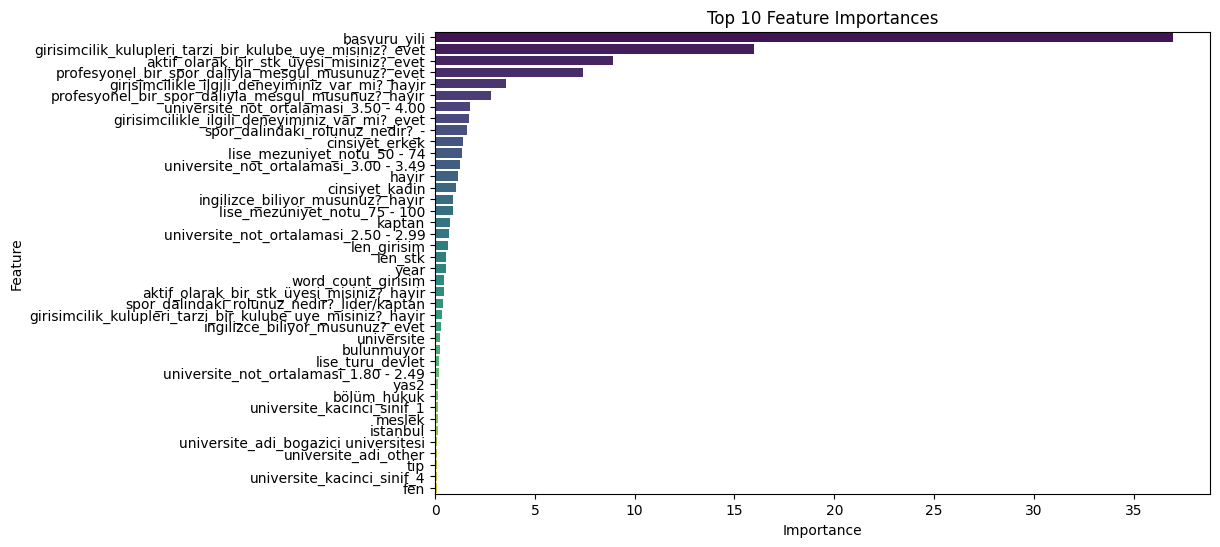

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


feature_importances_df = pd.DataFrame(feature_importances, columns= voting_regressor.estimators_[0].feature_names_)
average_importances = feature_importances_df.mean(axis=0)


feature_df = pd.DataFrame({
    'Feature': average_importances.index,
    'Importance': average_importances.values
})


top_features = feature_df.sort_values(by='Importance', ascending=False).head(40)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [27]:
test = pd.read_csv("/kaggle/input/datathon-2024/test_x.csv")

mean_predictions = np.mean(test_predictions, axis=0)
test["Degerlendirme Puani"] = mean_predictions
sub = test[["id","Degerlendirme Puani"]]

sub.to_csv("submission.csv",index=False)